In [1]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd 
import torch 
import tensorflow as tf 
from tensorflow import keras 
import sklearn 
import matplotlib.pyplot as plt 
import seaborn as sns 
import cudf , cupy 

from tqdm import tqdm 
import tensorflow_addons as tfa

In [2]:
# Matplotlib global settings 

import matplotlib as mpl 

mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12 
mpl.rcParams['axes.labelsize'] = 16 
mpl.rcParams['axes.titlesize'] = 20 

# Data Processing 

In [3]:
train_path = '/kaggle/input/asl-signs/train.csv'
sign2pred = '/kaggle/input/asl-signs/sign_to_prediction_index_map.json'

train_csv = pd.read_csv(train_path)

print("Train shape : "  , train_csv.shape)
display(train_csv.head())

Train shape :  (94477, 4)


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [4]:
sign2pred = pd.read_json('/kaggle/input/asl-signs/sign_to_prediction_index_map.json',
                         orient = 'index' ).to_dict()


train_csv['path'] = '/kaggle/input/asl-signs/' + train_csv['path']
train_csv['sign_index'] = train_csv['sign'].apply(lambda x : sign2pred[0][x])

display(train_csv.head())

,path,participant_id,sequence_id,sign,sign_index
0,/kaggle/input/asl-signs/train_landmark_files/2...,26734,1000035562,blow,25
1,/kaggle/input/asl-signs/train_landmark_files/2...,28656,1000106739,wait,232
2,/kaggle/input/asl-signs/train_landmark_files/1...,16069,100015657,cloud,48
3,/kaggle/input/asl-signs/train_landmark_files/2...,25571,1000210073,bird,23
4,/kaggle/input/asl-signs/train_landmark_files/6...,62590,1000240708,owie,164


***LET'S START*** 

In [5]:
# N_SAMPLES = train_csv.shape[0]
# N_COLS = 66
# N_DIMS = 3

# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GroupShuffleSplit

# train = train_csv

# X = np.zeros(shape = [int(N_SAMPLES) , INPUT_SIZE , N_COLS , N_DIMS])
# Y = np.zeros(shape = [int(N_SAMPLES)])
# NON_EMPTY_FRAME_INDICES = np.full([int(N_SAMPLES) , INPUT_SIZE] , -1)

# for i , file_path in enumerate(tqdm(train['path'].iloc[:45000])):
#     data , non_empty_frame_indices = get_data(file_path)
#     NON_EMPTY_FRAME_INDICES[i] = non_empty_frame_indices 

#     X[i] = data
#     Y[i] = train_csv.iloc[i].sign_index 

#     if(np.isnan(data).sum() > 0):
#         print(i)
        

# np.save('X.npy' , X)
# np.save('Y.npy' , Y)
# np.save('NON_EMPTY_FRAME_INDICES.npy' , NON_EMPTY_FRAME_INDICES)

# #X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y,test_size = 0.25)
# splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=42)
# PARTICIPANT_IDS = train['participant_id'].values

# train_idxs, val_idxs = next(splitter.split(X,Y, groups=PARTICIPANT_IDS))


# X_TRAIN = X[train_idxs]
# NON_EMPTY_FRAME_TRAIN_IDXS = NON_EMPTY_FRAME_INDICES[train_idxs]
# Y_TRAIN = Y[train_idxs]
# np.save('X_train.npy', X_TRAIN)
# np.save('y_train.npy', Y_TRAIN)
# np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_TRAIN_IDXS)

# X_VAL = X[val_idxs]
# NON_EMPTY_FRAME_VAL_IDXS = NON_EMPTY_FRAME_INDICES[val_idxs]
# Y_VAL = Y[val_idxs]
# np.save('X_val.npy', X_VAL)
# np.save('y_val.npy', Y_VAL)
# np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_VAL_IDXS)

# print(f'X_Train.shape : {X_TRAIN.shape} , Y_Train.shape : {Y_TRAIN.shape}')
# print(f'X_Test.shape : {X_VAL.shape} , Y_Test.shape : {Y_VAL.shape}')

In [6]:
XTrain_path = '/kaggle/input/gislr-dataset-public/X_train.npy'
YTrain_path = '/kaggle/input/gislr-dataset-public/y_train.npy'
non_empty_Train_path = '/kaggle/input/gislr-dataset-public/NON_EMPTY_FRAME_IDXS_TRAIN.npy'

XVal_path = '/kaggle/input/gislr-dataset-public/X_val.npy'
YVal_path = '/kaggle/input/gislr-dataset-public/y_val.npy'
non_empty_Val_path = '/kaggle/input/gislr-dataset-public/NON_EMPTY_FRAME_IDXS_VAL.npy'

X_TRAIN = np.load(XTrain_path)
Y_TRAIN = np.load(YTrain_path)
NON_EMPTY_FRAME_TRAIN_IDXS = np.load(non_empty_Train_path)
validation_data = None

# X_VAL = np.load(XVal_path)
# Y_VAL = np.load(YVal_path)
# NON_EMPTY_FRAME_VAL_IDXS = np.load(non_empty_Val_path)

In [7]:
X_VAL = np.load(XVal_path)
Y_VAL = np.load(YVal_path)
NON_EMPTY_FRAME_VAL_IDXS = np.load(non_empty_Val_path)

In [8]:
USETYPES = ['left_hand' , 'pose' , 'right_hand'] 
LEFT_HAND_IDX = np.arange(468 , 489)
RIGHT_HAND_IDX = np.arange(522 , 543)
LEFTHAND_POSE_IDX = np.array([502,504,506,508,510])
RIGHTHAND_POSE_IDX = np.array([503,505,507,509,511])

LIPS_IDX = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

LEFTHAND_DOMINANT_IDX = np.concatenate([LIPS_IDX , LEFT_HAND_IDX , LEFTHAND_POSE_IDX])
RIGHTHAND_DOMINANT_IDX = np.concatenate([LIPS_IDX , RIGHT_HAND_IDX , RIGHTHAND_POSE_IDX])

LIPS_IND = np.argwhere(np.isin(LEFTHAND_DOMINANT_IDX , LIPS_IDX)).squeeze()
LEFTHAND_IND = np.argwhere(np.isin(LEFTHAND_DOMINANT_IDX , LEFT_HAND_IDX)).squeeze()
LEFTHAND_POSE_IND = np.argwhere(np.isin(LEFTHAND_DOMINANT_IDX , LEFTHAND_POSE_IDX)).squeeze()

print(LIPS_IND)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [9]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IND.size
POSE_START = LEFT_HAND_START + LEFTHAND_IND.size
# POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, POSE_START: 61


In [10]:
N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
NUM_CLASSES = 250
INPUT_SIZE = 64
N_COLS = LEFTHAND_DOMINANT_IDX.shape[0]

print(N_COLS)

66


In [11]:
# from sklearn.model_selection import GroupShuffleSplit

# preprocess_data()

# ROOT_DIR = '.'

# # X_TRAIN = np.load()
# # Y_TRAIN = np.load()

# # X_TEST = np.load()
# Y_TEST = np.load()

In [12]:
# X_TRAIN = np.load(f'{ROOT_DIR}/X_train.npy')
# Y_TRAIN = np.load(f'{ROOT_DIR}/y_train.npy')
# NON_EMPTY_FRAME_TRAIN_IDXS = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')

# X_TEST = np.load(f'{ROOT_DIR}/X_val.npy')
# Y_TEST = np.load(f'{ROOT_DIR}/y_val.npy')
# # NON_EMPTY_FRAME_TEST_IDXS = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')

# print('x_train shape : ' , X_TRAIN.shape)
# print('x_test shape : ' , X_TEST.shape)

# Feature Statistics - Lips

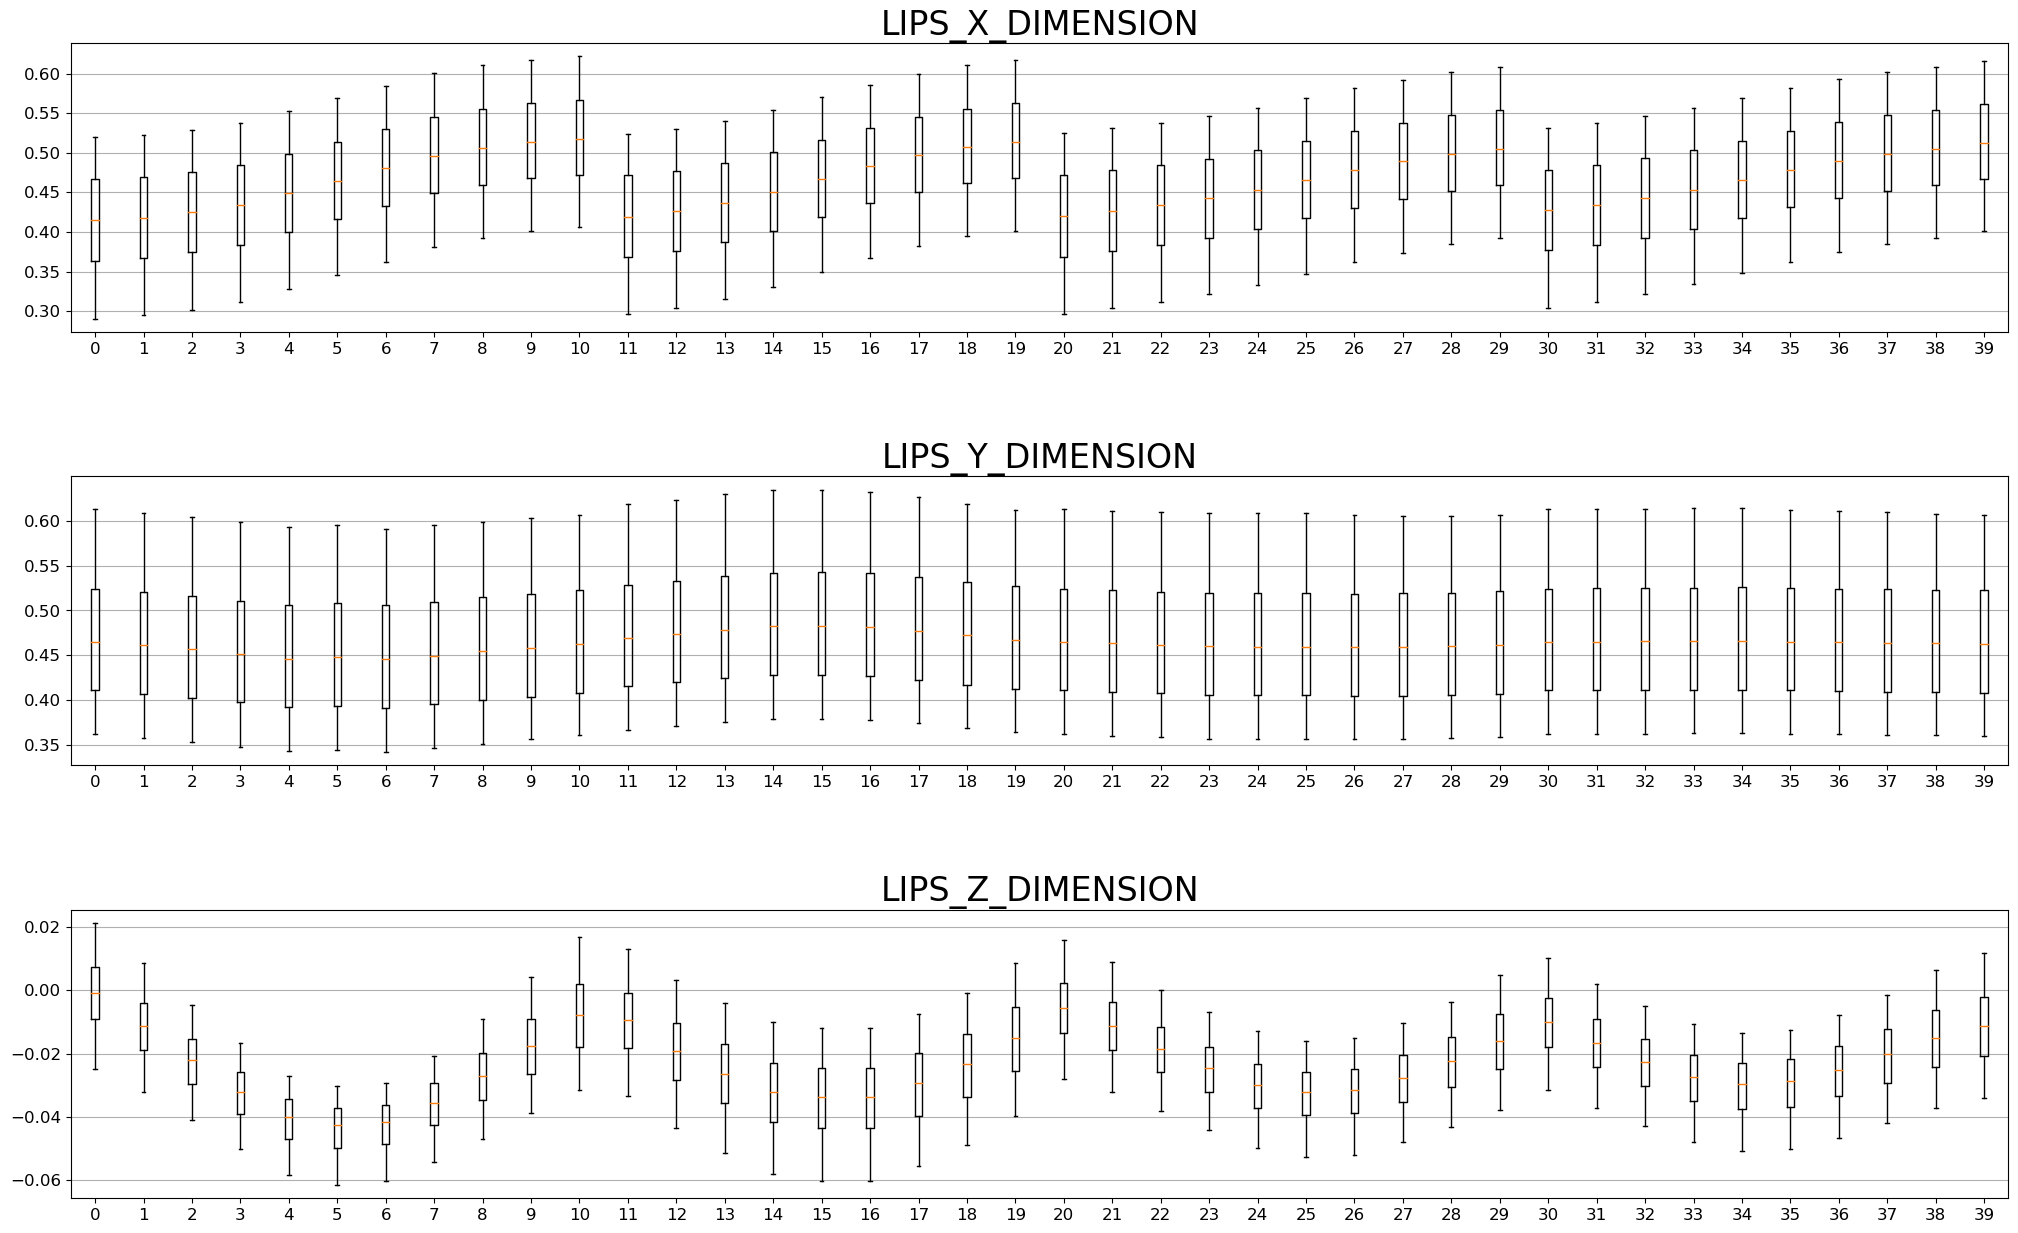

In [13]:
def get_mean_std(INDICES , feature):
    MEAN_X = np.zeros([INDICES.size])
    MEAN_Y = np.zeros([INDICES.size])
    STD_X = np.zeros([INDICES.size])
    STD_Y = np.zeros([INDICES.size])
    
    fig , axes = plt.subplots(3 , 1 , figsize = (25,15))
    
    for i , ll in enumerate(np.transpose(X_TRAIN[:,:,INDICES],[2,3,0,1]).reshape(INDICES.size , N_DIMS , -1)):
        for dim , v in enumerate(ll):
            v = v[np.nonzero(v)]
            if(dim == 0):
                MEAN_X[i] = v.mean()
                STD_X[i] = v.std()
            elif(dim == 1):
                MEAN_Y[i] = v.mean()
                STD_Y[i] = v.std()
                
            axes[dim].boxplot(v , notch = False , showfliers = False , positions = [i] , whis = [5,95])
        
    for ax , dim_name in zip(axes , DIM_NAMES):
        ax.set_title(f'{feature}_{dim_name.upper()}_DIMENSION',size = 24)
        ax.tick_params(axis = 'x',labelsize = 12)
        ax.grid(axis = 'y')
        
    plt.subplots_adjust(hspace=0.50)
    plt.show()
                
    MEAN_ARRAY = np.array([MEAN_X , MEAN_Y]).T 
    STD_ARRAY = np.array([STD_X , STD_Y]).T 
    
    return MEAN_ARRAY , STD_ARRAY 
    
LIPS_MEAN_ARRAY , LIPS_STD_ARRAY = get_mean_std(LIPS_IND , 'LIPS')

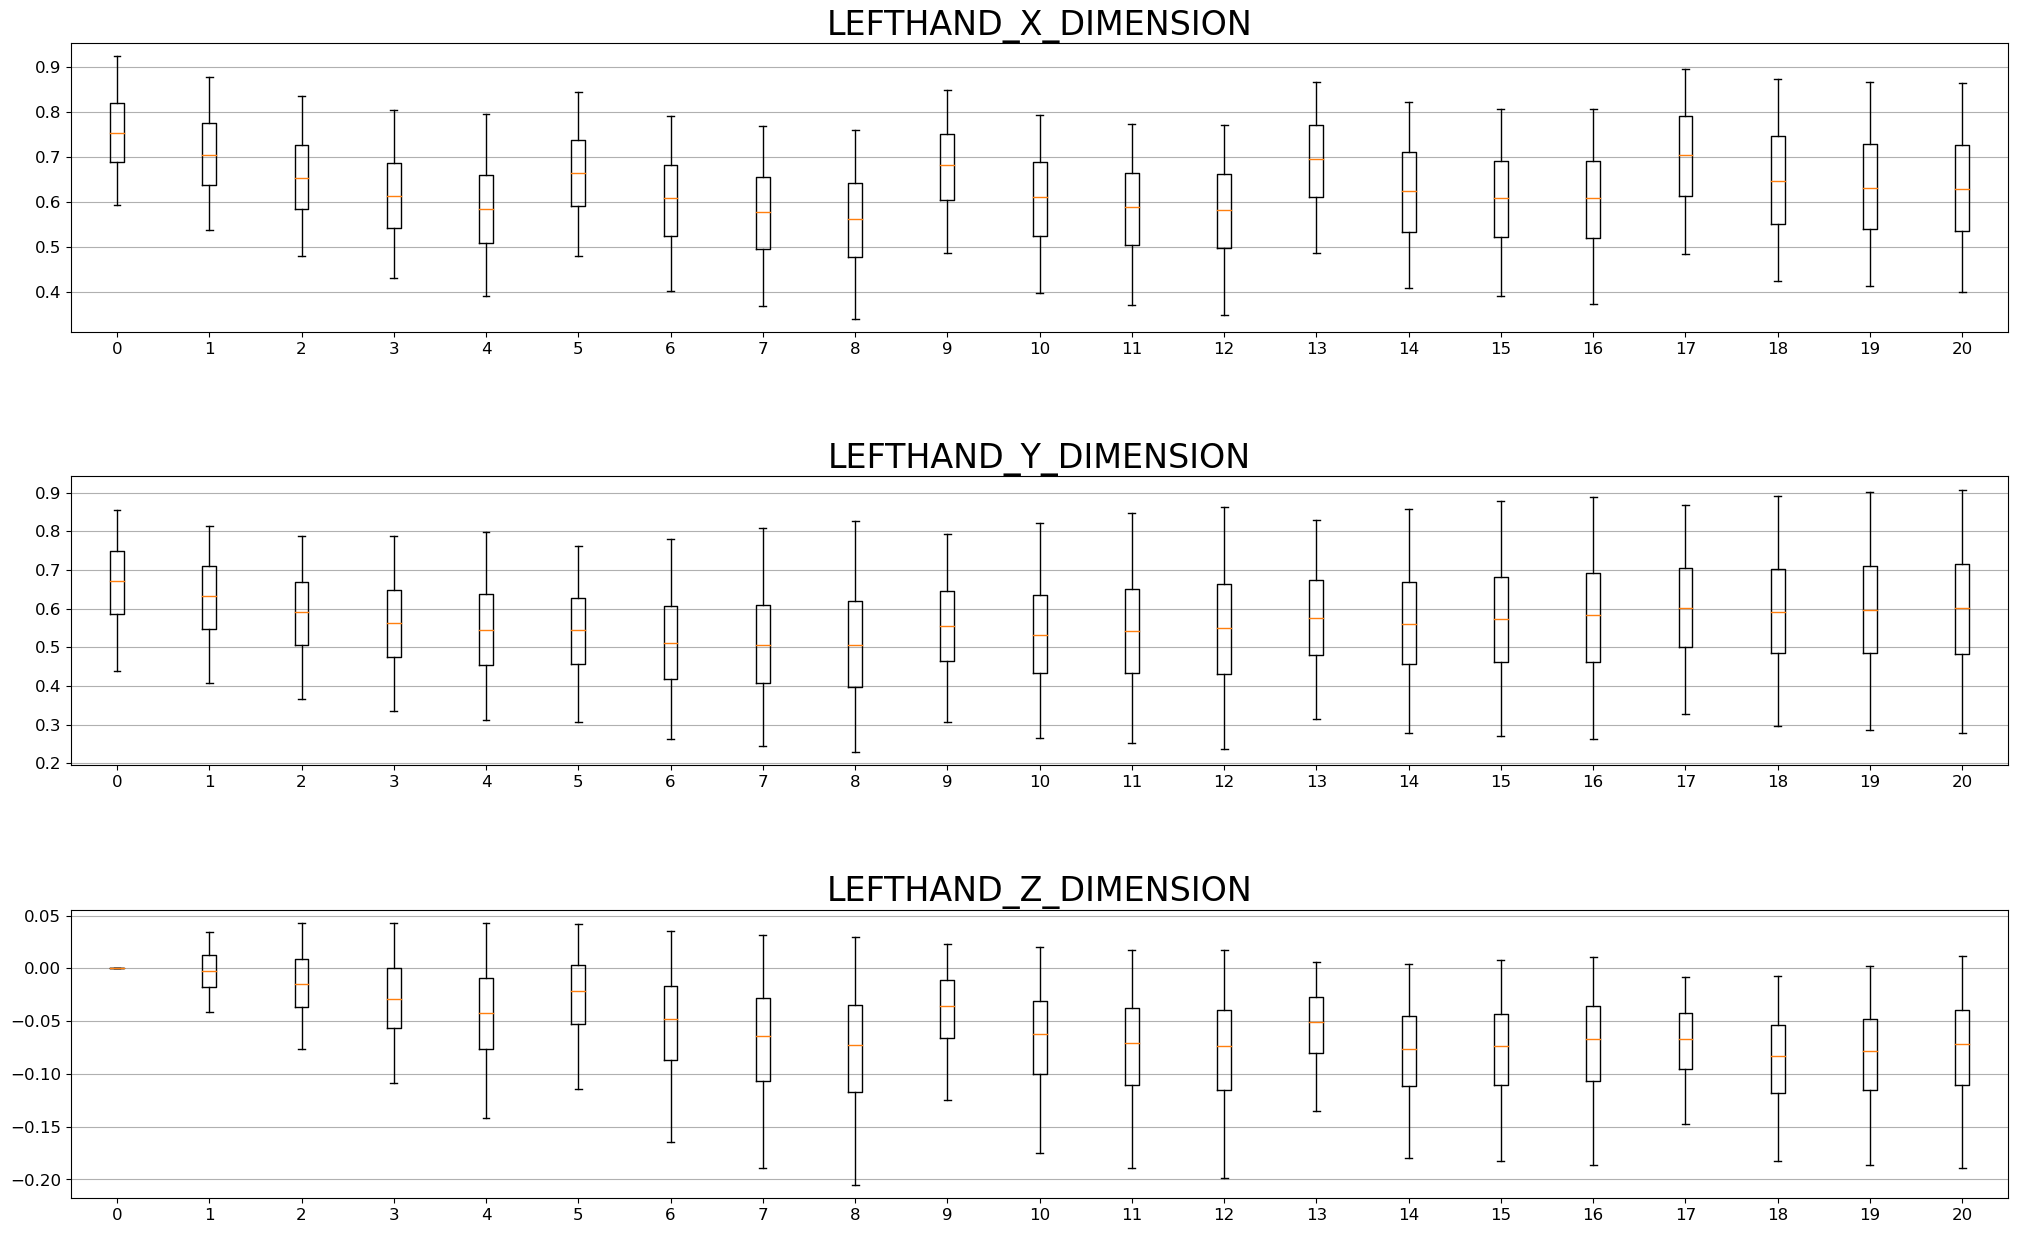

In [14]:
LEFTHAND_MEAN_ARRAY ,LEFTHAND_STD_ARRAY = get_mean_std(LEFTHAND_IND , 'LEFTHAND') 

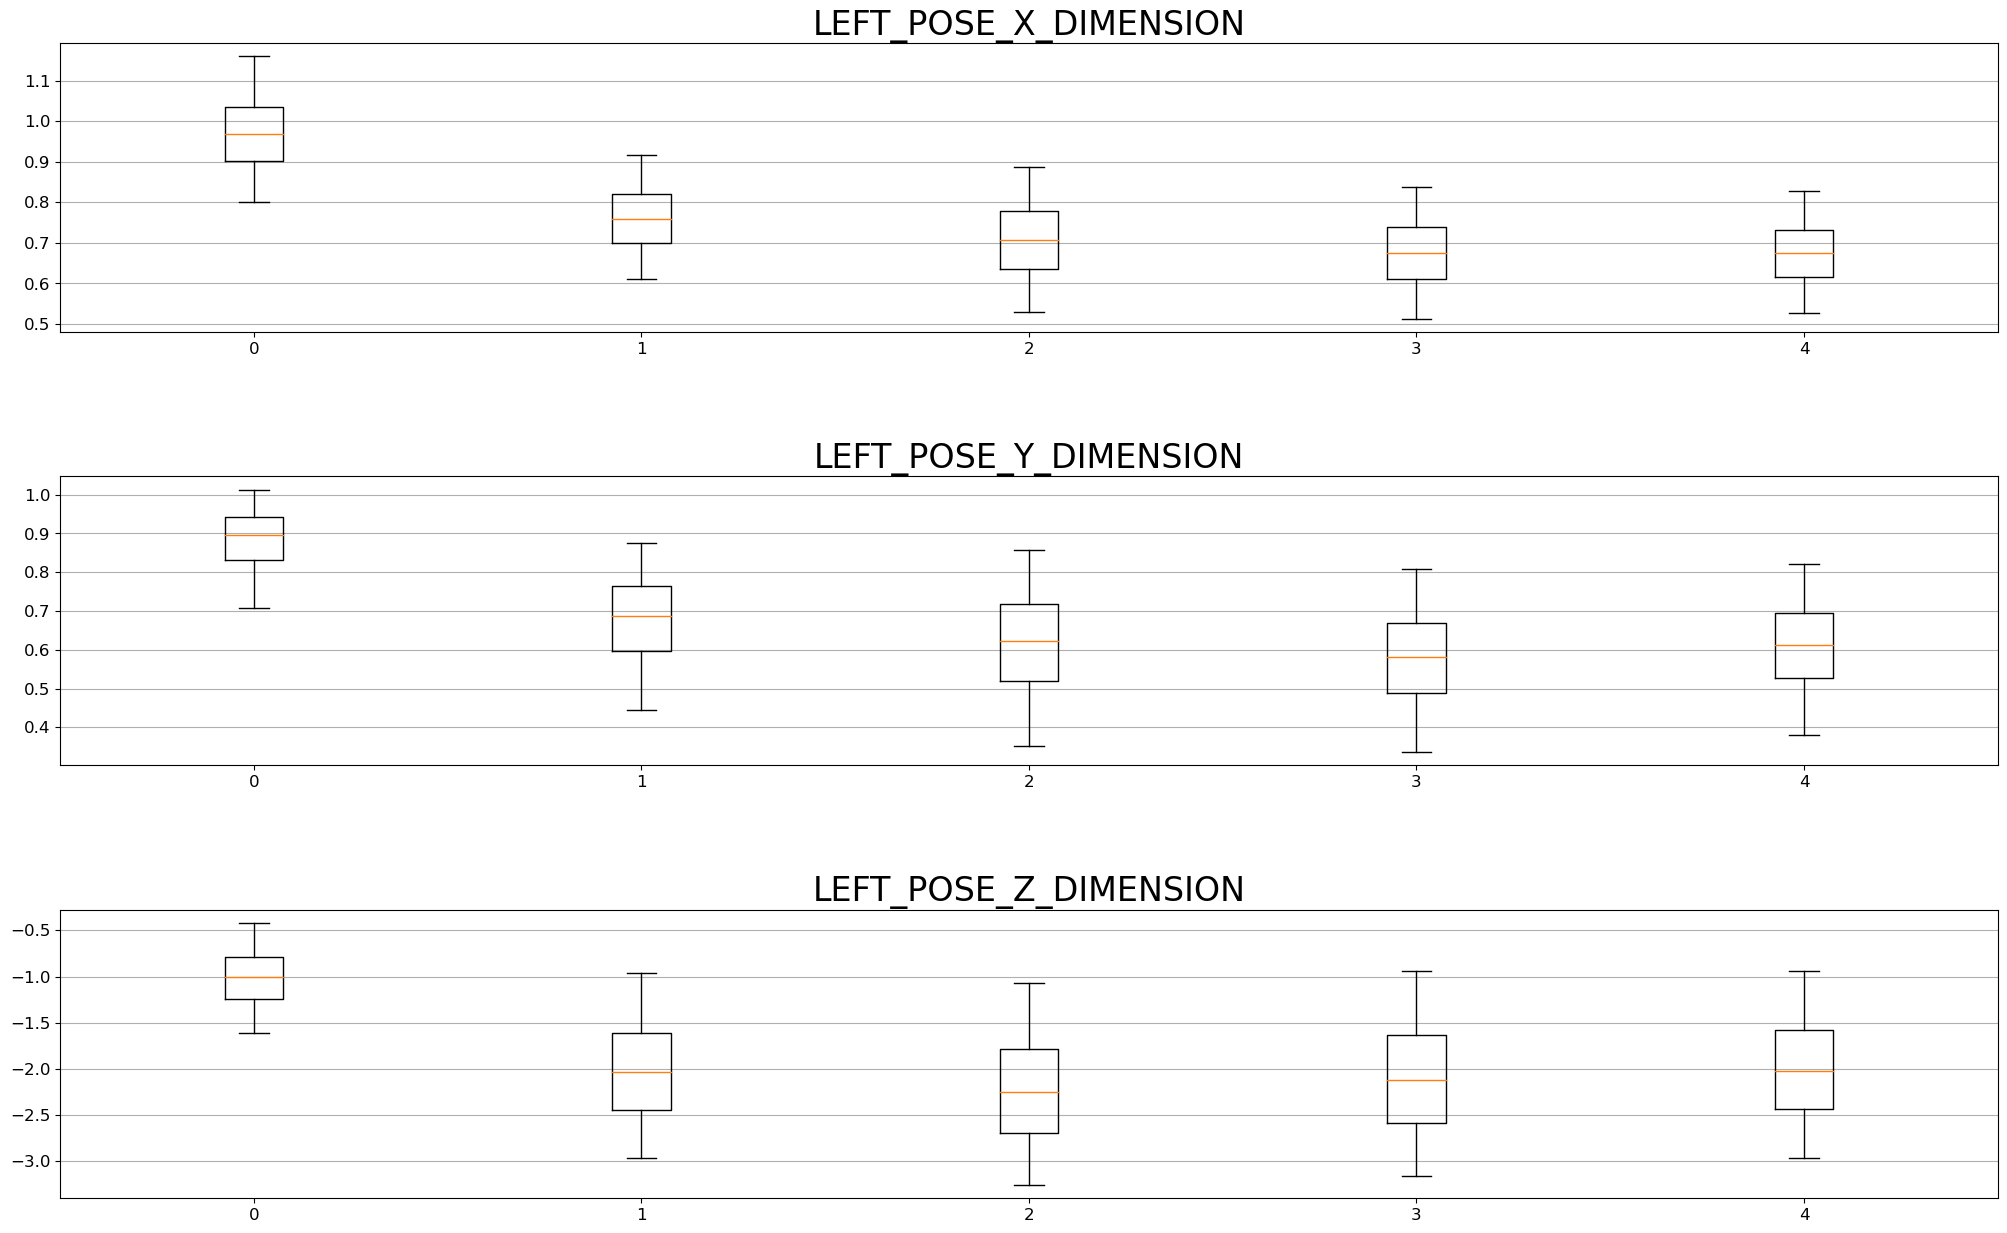

In [15]:
LEFTHAND_POSE_MEAN_ARRAY , LEFTHAND_POSE_STD_ARRAY = get_mean_std(LEFTHAND_POSE_IND , 'LEFT_POSE')

In [16]:
INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 4
NUM_CLASSES = 250

In [17]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [18]:
validation_data = get_train_batch_all_signs(X_VAL, Y_VAL, NON_EMPTY_FRAME_VAL_IDXS)

In [19]:
dummy_dataset = get_train_batch_all_signs(X_TRAIN, Y_TRAIN, NON_EMPTY_FRAME_TRAIN_IDXS)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    print(f'{k} shape: {v.shape}, dtype: {v.dtype}')


print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
#Verify each sign is contained 4 times in a batch
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

frames shape: (1000, 64, 66, 3), dtype: float32
non_empty_frame_idxs shape: (1000, 64), dtype: float32
y_batch shape: (1000,), dtype: int64


,Counts
0,4
171,4
158,4
159,4
160,4
...,...
88,4
89,4
90,4
91,4


In [20]:
# # CREATING DATA BATCHES 

# batch_size = 16
# Train_dataset = tf.data.Dataset.from_tensor_slices(({'frames' : X_TRAIN ,
#                                                      'non_empty_frame_idxs' : NON_EMPTY_FRAME_TRAIN_IDXS} , Y_TRAIN)).batch(batch_size) 
# # Train_dataset = Train_dataset.shuffle(buffer_size = len(X_TRAIN))
# # Train_dataset = Train_dataset.batch(batch_size) 
# # Val_dataset = Val_dataset.shuffle(buffer_size = len(X_VAL))
# # Val_dataset = Val_dataset.batch(batch_size) 

# del X_TRAIN , Y_TRAIN , NON_EMPTY_FRAME_TRAIN_IDXS

# # Val_dataset = tf.data.Dataset.from_tensor_slices(({'frames' : X_VAL , 
# #                                                    'non_empty_frame_idxs' : NON_EMPTY_FRAME_VAL_IDXS} , Y_VAL)).batch(batch_size)

# # del X_VAL , Y_VAL , NON_EMPTY_FRAME_VAL_IDXS

# Modelling

In [21]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512
NUM_HEADS = 4

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)

# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 512


**TRANSFORMER**

In [22]:
def scaled_dot_product_attention(q , k,v , softmax , attention_mask):
    qkt = tf.matmul(q , k , transpose_b = True)
    dk = tf.math.sqrt(tf.cast(q.shape[-1] , dtype = tf.float32))
    scaled = qkt/dk
    softmax = softmax(scaled , mask = attention_mask)
    
    scaled_v = tf.matmul(softmax , v)
    
    return scaled_v    

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self , d_model , num_heads):
        super().__init__()
        self.d_model = d_model 
        self.num_heads = num_heads 
        self.depth = d_model//num_heads 
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_heads)]
        
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self ,x , attention_mask):
        mha = []
        for i in range(self.num_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            scaled_v = scaled_dot_product_attention(Q,K,V,self.softmax , attention_mask)
            mha.append(scaled_v)
        
        multi_head = tf.concat(mha , axis = -1)
        multi_head_attention = self.wo(multi_head)
        
        return multi_head_attention

In [24]:
# FULL TRANSFORMER 

class Transformer(tf.keras.Model):
    def __init__(self , num_blocks):
        super().__init__()
        self.num_blocks = num_blocks 
        
    def build(self , input_shape):
        self.mhas = []
        self.mlps = []
        
        for i in range(self.num_blocks):
            self.mhas.append(MultiHeadAttention(UNITS , NUM_HEADS))
            
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
            
            
    def call(self , x , attention_mask):
        for mha , mlp in zip(self.mhas , self.mlps):
            x = x + mha(x , attention_mask)
            x = x + mlp(x)
            
        return x

# Landmark Embeddings

In [25]:
class LandMarkEmbeddings(tf.keras.Model):
    def __init__(self , units):
        super(LandMarkEmbeddings , self).__init__()
        self.units = units
    
    def build(self , input_shape):
        self.empty_embeddings = self.add_weight(shape = [self.units] , initializer = INIT_ZEROS) 
        
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units , activation = 'relu')
        ])
    
    def call(self , x):
        return tf.where(tf.reduce_sum(x , axis = 2 , keepdims = True) == 0 , self.empty_embeddings , self.dense(x))

# Embedding

In [26]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding , self).__init__()
    
    def build(self , input_shape):
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1 , UNITS , embeddings_initializer=INIT_ZEROS) 
        self.lips_landmarks_embedding = LandMarkEmbeddings(LIPS_UNITS)
        self.pose_landmarks_embedding = LandMarkEmbeddings(POSE_UNITS)
        self.hands_landmarks_embedding = LandMarkEmbeddings(HANDS_UNITS)
        
        self.landmark_weights = tf.Variable(tf.zeros([3] , dtype = tf.float32) , name = 'landmark_weights')
        
        self.fc = tf.keras.layers.Dense(UNITS , activation = 'relu')
    
    def call(self , lips , pose , hands , non_empty_frame_idxs , training = False):
        lips_embed = self.lips_landmarks_embedding(lips)
        print('LIPS OKAY')
        pose_embed = self.pose_landmarks_embedding(pose)
        print('POSE OKAY')
        hands_embed = self.hands_landmarks_embedding(hands) 
        print('HANDS OKAY')
        
        x = tf.stack((lips_embed , pose_embed , hands_embed),axis = 3) 
        x = x*tf.nn.softmax(self.landmark_weights) 
        x = tf.reduce_sum(x,axis = 3)
        x = self.fc(x)
        
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

In [27]:
def scle_with_ls(y_true , y_pred):
    y_true = tf.cast(y_true , tf.int32)
    y_true = tf.one_hot(y_true , NUM_CLASSES , axis = 1)
    y_true = tf.squeeze(y_true , axis = 2)
    return tf.keras.losses.categorical_crossentropy(y_true , y_pred , label_smoothing = 0.25)

In [28]:
def get_model():
    # Input Shape 
    frames = tf.keras.layers.Input([INPUT_SIZE , N_COLS , N_DIMS] , dtype = tf.float32 , name = 'frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype = tf.float32 , name = 'non_empty_frame_idxs')
    
    # masking 
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs , -1) , dtype = tf.float32)
    mask0 = tf.expand_dims(mask0 , axis = 2 ) 
    
#     print(f'Mask0 : {mask0.shape , mask0}')
    
    # RANDOM FRAME MASKING 
    mask = tf.where((tf.random.uniform(tf.shape(mask0)) > 0.25) & (tf.math.not_equal(mask0 , 0.0)) , 1.0 ,0.0)
    
#     print(f'Mask : {mask.shape , mask}')
    
    mask = tf.where(
    tf.math.equal(tf.reduce_sum(mask,axis = [1,2] , keepdims = True) , 0.0), mask0 , mask)
    
#     print(f'mask : {mask.shape , mask}')
    
    # LIPS 
    x = frames 
    x = tf.slice(x , [0,0,0,0] , [-1,INPUT_SIZE , N_COLS , 2])
    
    print('Step 1')
    
    LIPS = tf.slice(x , [0,0,LIPS_START,0] , [-1,INPUT_SIZE ,40 ,2])
    lips = tf.where(tf.math.equal(LIPS , 0.0),0.0 , (LIPS - LIPS_MEAN_ARRAY)/LIPS_STD_ARRAY)
    
    print('Step 2')
    
    HANDS = tf.slice(x , [0,0,40,0] , [-1,INPUT_SIZE ,21 ,2])
    hands = tf.where(tf.math.equal(HANDS , 0.0),0.0 , (HANDS - LEFTHAND_MEAN_ARRAY)/LEFTHAND_STD_ARRAY)
    
    print('Step 3')
    
    POSE = tf.slice(x , [0,0,61,0] , [-1,INPUT_SIZE ,5 ,2])
    poses = tf.where(tf.math.equal(POSE , 0.0),0.0 , (POSE - LEFTHAND_POSE_MEAN_ARRAY)/LEFTHAND_POSE_STD_ARRAY)
    
    print('Step 4')
    
    lips = tf.reshape(lips , [-1,INPUT_SIZE,40*2])
    left_hand = tf.reshape(hands , [-1,INPUT_SIZE , 21*2])
    pose = tf.reshape(poses , [-1,INPUT_SIZE , 5*2])
    
    print('Step 5')
    
    
    x = Embedding()(lips , left_hand , pose , non_empty_frame_idxs)
    
    print('Embedding OKAY')
    
    x = Transformer(NUM_BLOCKS)(x , mask)
    
    print('Transformer OKAY')
    
    # Pooling 
    x = tf.reduce_sum(x*mask , axis = 1)/tf.reduce_sum(mask , axis = 1) 
    
    print('Pooling OKAY')
    
    x = tf.keras.layers.Dense(NUM_CLASSES , activation = tf.keras.activations.softmax)(x) 
    
    print('Dense OKAY')
    
    outputs = x 
    
    model = tf.keras.models.Model(inputs = [frames , non_empty_frame_idxs] , outputs  = outputs)
    
    loss = scle_with_ls 
    
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    metrics = [
       tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
       tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
       tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss = loss , optimizer = optimizer , metrics = metrics)
    
    return model 

# Learning Rate Scheduler 

In [30]:
N_EPOCHS = 50
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05

In [31]:
import math

def lrfn(current_step , num_warmup_steps , lr_max ,num_cycles = 0.5, num_training_steps = N_EPOCHS):
    if current_step < num_warmup_steps:
            return lr_max * 0.1**(-current_step+num_warmup_steps)
    else:
        progress = float(current_step- num_warmup_steps)/max(1,num_training_steps-num_warmup_steps) 
        
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [32]:
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

In [33]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

 # TRAINING MODEL

In [35]:
tf.keras.backend.clear_session()

BATCH_SIZE = 256
model = get_model()

# Sanity Check
model.summary()

history = model.fit(
    x=get_train_batch_all_signs(X_TRAIN, Y_TRAIN, NON_EMPTY_FRAME_TRAIN_IDXS),
    steps_per_epoch=len(X_TRAIN) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_data,
    validation_steps = 20,
    callbacks=[
        lr_callback,
        WeightDecayCallback(),
    ],
    verbose = 1,
)

Step 1
Step 2
Step 3
Step 4
Step 5
LIPS OKAY
POSE OKAY
HANDS OKAY
Embedding OKAY
Transformer OKAY
Pooling OKAY
Dense OKAY
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               
 er)                                                                                              
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      
                                                                       

In [ ]:
model.save_weights('weights.h5')

In [36]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    val_values = history.history[f'val_{metric}']
    N_EPOCHS = len(values)
    
    x_ticks = np.arange(1, N_EPOCHS+1)
    x = np.arange(1, N_EPOCHS + 1,5)
    
    plt.plot(x_ticks, values, label=f'train')
    plt.plot(x_ticks , val_values , label = f'Validation')
    
    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()
    

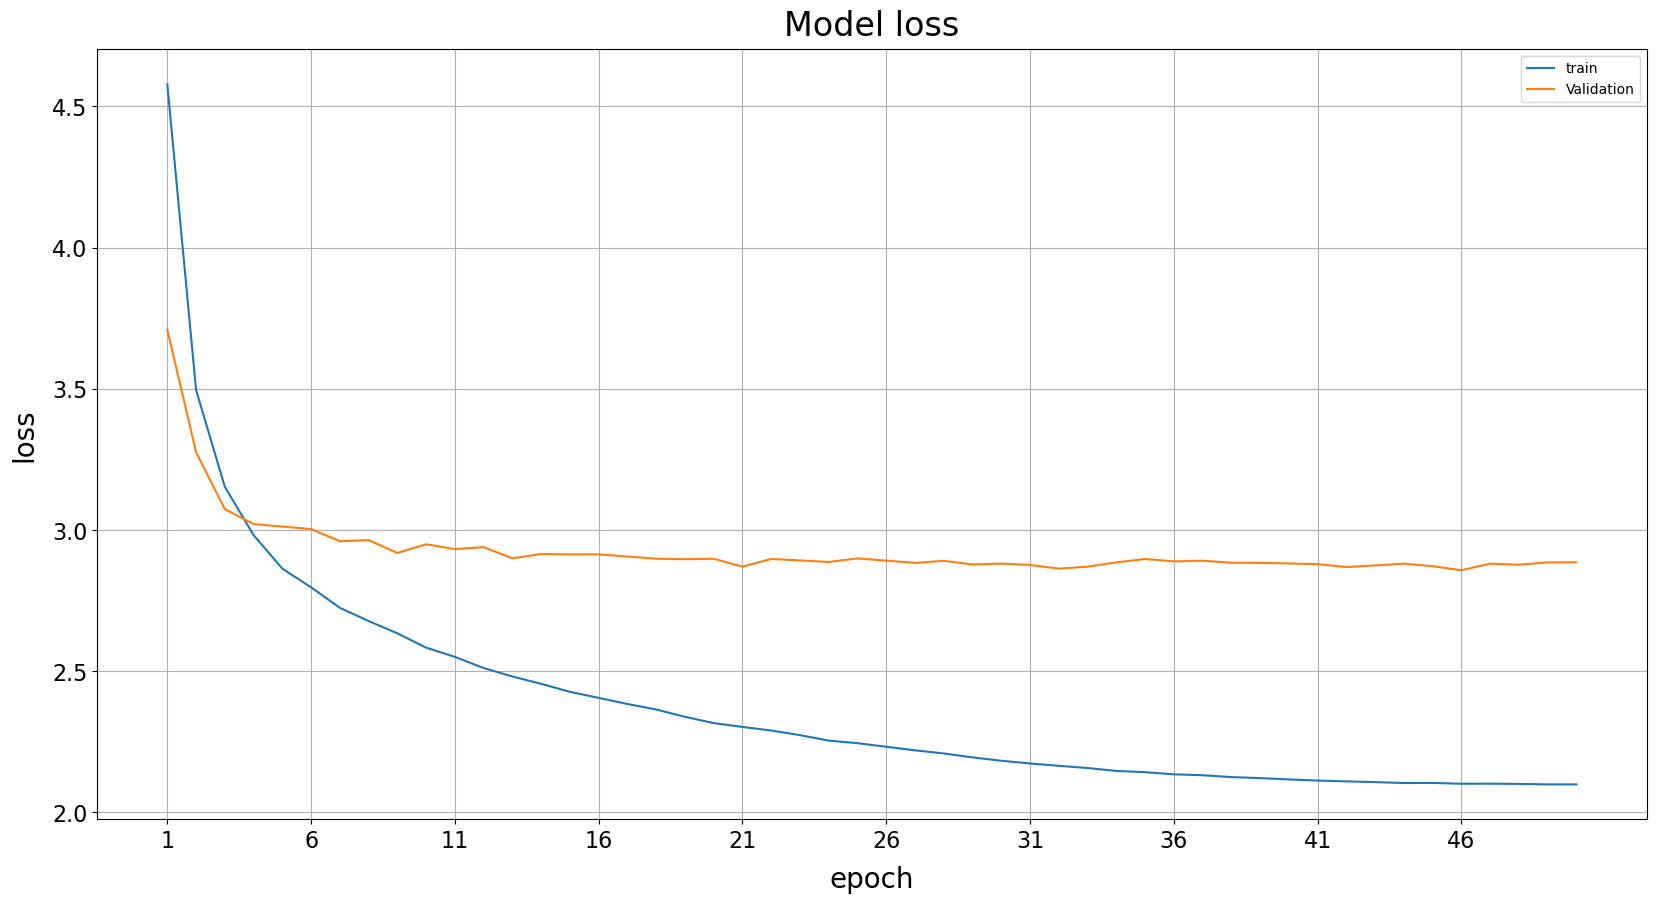

<Figure size 640x480 with 0 Axes>

In [37]:
plot_history_metric('loss')
plt.savefig('loss.png')

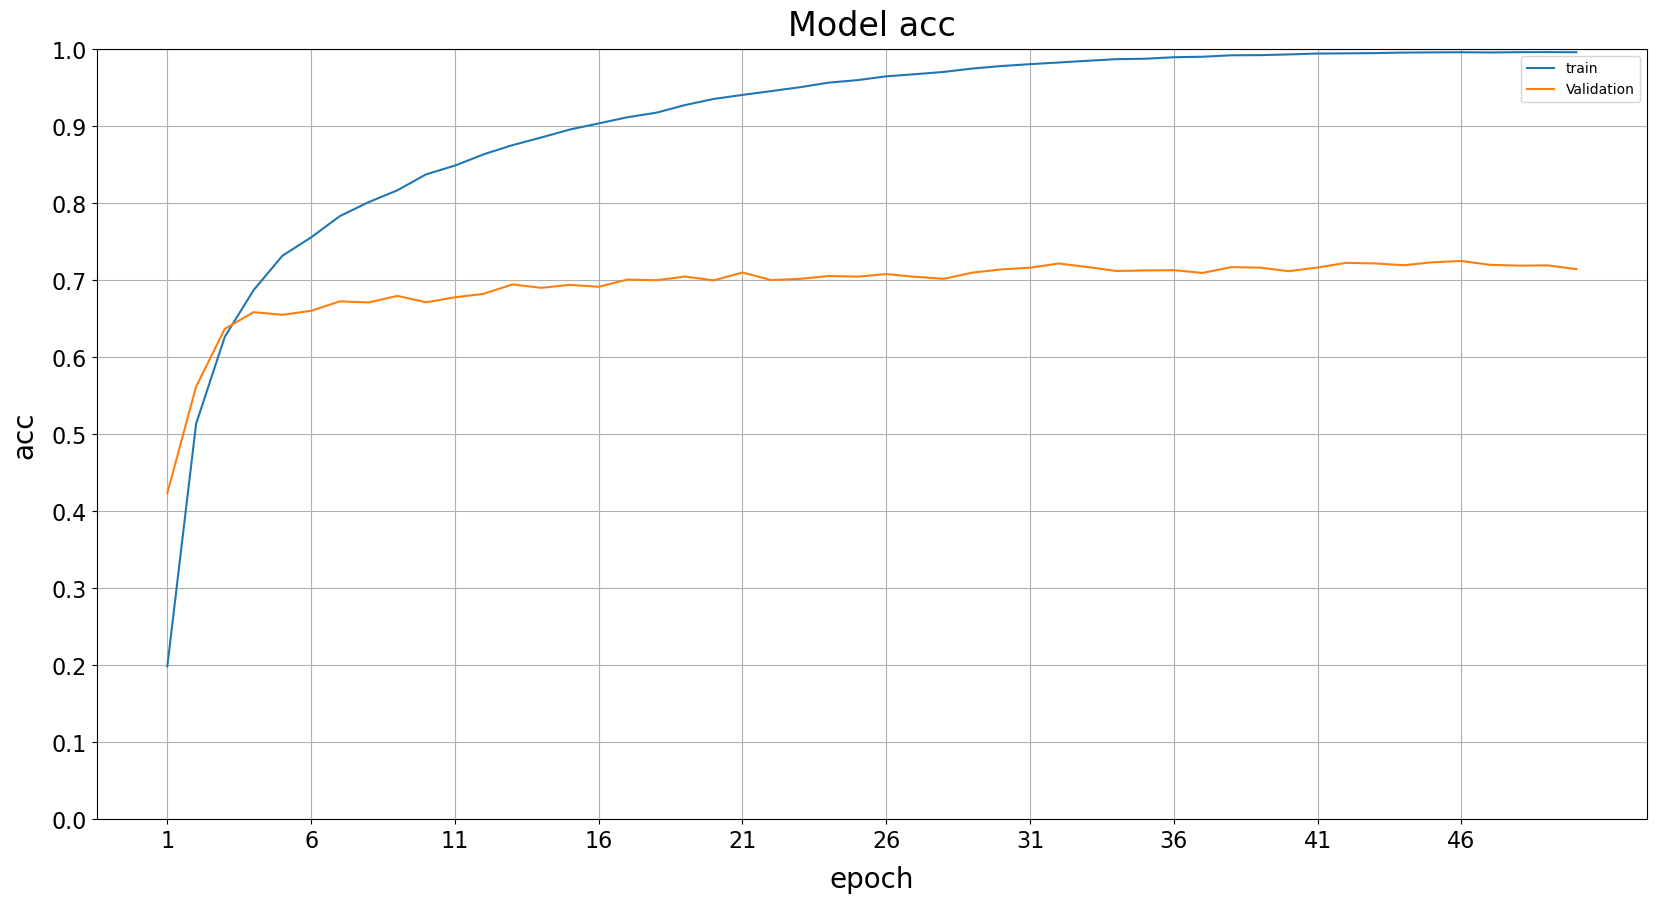

<Figure size 640x480 with 0 Axes>

In [38]:
plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))
plt.savefig('acc.png')

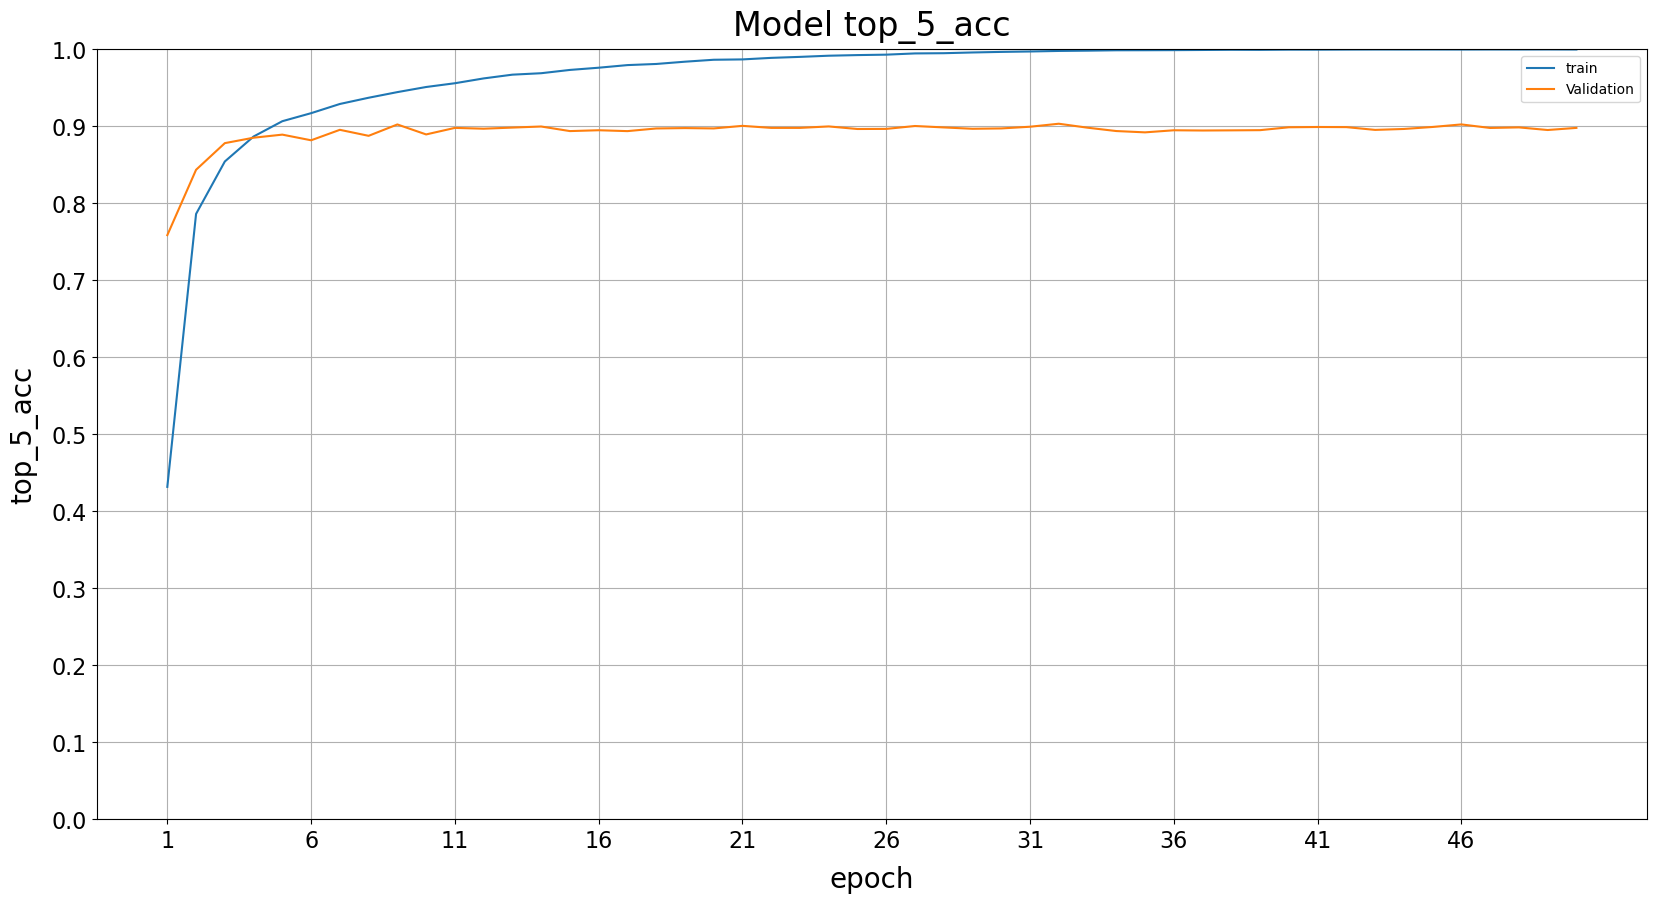

<Figure size 640x480 with 0 Axes>

In [39]:
plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))
plt.savefig('top_5_acc.png')